### Agentic RAG

In [28]:
from dotenv import load_dotenv

load_dotenv()

True

In [29]:
from langchain_teddynote import logging

logging.langsmith("edu-Agentic-RAG")

LangSmith 추적을 시작합니다.
[프로젝트명]
edu-Agentic-RAG


### PDF 기반 Retrieval Chain

In [30]:
from rag.pdf import PDFRetrievalChain

pdf = PDFRetrievalChain(["data/SPRI_AI_Brief_2023년12월호_F.pdf"]).create_chain()

pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

In [18]:
# test
from langchain_core.tools.retriever import create_retriever_tool
from langchain_core.prompts import PromptTemplate

retriever_tool = create_retriever_tool(
    pdf_retriever, 
    "pdf_retriever",
    "Search and return information about SPRI AI Brief PDF file. It contains useful information on recent AI trends. The document is published on Dec 2023.",
    # document_prompt=PromptTemplate.from_template(
    #     "<document><context>{page_content}</context><metadata><source>{source}</source><page>{page}</page></metadata></document>"
    # ),
)
print(retriever_tool.invoke("삼성전자가 개발한 생성현 AI의 이름은?"))

SPRi AI Brief |
2023-12월호
삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개
KEY Contents
n 삼성전자가 온디바이스에서 작동 가능하며 언어, 코드, 이미지의 3개 모델로 구성된 자체 개발 생성
AI 모델 ‘삼성 가우스’를 공개
n 삼성전자는 삼성 가우스를 다양한 제품에 단계적으로 탑재할 계획으로, 온디바이스 작동이 가능한
삼성 가우스는 외부로 사용자 정보가 유출될 위험이 없다는 장점을 보유
£언어, 코드, 이미지의 3개 모델로 구성된 삼성 가우스, 온디바이스 작동 지원

▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10
▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11
▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12

어시스턴트를 적용한 구글 픽셀(Pixel)과 경쟁할 것으로 예상
☞ 출처 : 삼성전자, ‘삼성 AI 포럼’서 자체 개발 생성형 AI ‘삼성 가우스’ 공개, 2023.11.08.
삼성전자, ‘삼성 개발자 콘퍼런스 코리아 2023’ 개최, 2023.11.14.
TechRepublic, Samsung Gauss: Samsung Research Reveals Generative AI, 2023.11.08.
10

£언어, 코드, 이미지의 3개 모델로 구성된 삼성 가우스, 온디바이스 작동 지원
n 삼성전자가 2023년 11월 8일 열린 ‘삼성 AI 포럼 2023’ 행사에서 자체 개발한 생성 AI 모델
‘삼성 가우스’를 최초 공개
∙ 정규분포 이론을 정립한 천재 수학자 가우스(Gauss)의 이름을 본뜬 삼성 가우스는 다양한 상황에
최적화된 크기의 모델 선택이 가능
∙ 삼성 가우스는 라이선스나 개인정보를 

In [19]:
from langchain_core.tools.retriever import create_retriever_tool
from langchain_core.prompts import PromptTemplate

retriever_tool = create_retriever_tool(
    pdf_retriever, 
    "pdf_retriever",
    "Search and return information about SPRI AI Brief PDF file. It contains useful information on recent AI trends. The document is published on Dec 2023.",
    document_prompt=PromptTemplate.from_template(
        "<document><context>{page_content}</context><metadata><source>{source}</source><page>{page}</page></metadata></document>"
    ),
)

tools = [retriever_tool]

In [20]:
retriever_tool

Tool(name='pdf_retriever', description='Search and return information about SPRI AI Brief PDF file. It contains useful information on recent AI trends. The document is published on Dec 2023.', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x000001DD34EE4720>, retriever=VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x000001DD788CE690>, search_kwargs={'k': 10}), document_prompt=PromptTemplate(input_variables=['page', 'page_content', 'source'], input_types={}, partial_variables={}, template='<document><context>{page_content}</context><metadata><source>{source}</source><page>{page}</page></metadata></document>'), document_separator='\n\n', response_format='content'), coroutine=functools.partial(<function _aget_relevant_documents at 0x000001DD34EE4860>, retriever=VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=

Agent 상태

In [31]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

노드와 엣지

In [41]:
from typing import Literal
from langchain import hub
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import tools_condition
from langchain_teddynote.models import get_model_name, LLMs

MODEL_NAME = get_model_name(LLMs.GPT4)

class grade(BaseModel):
    """A binary score for relevance checks"""

    binary_score: str = Field(
        description="Response 'yes' if the document is relevant to the question or 'no' if it is not."
    )

def grade_documents(state) -> Literal["generate", "rewrite"]:
    model = ChatOpenAI(temperature=0, model=MODEL_NAME, streaming=True)
    
    llm_with_tool = model.with_structured_output(grade)
    
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )
    
    chain = prompt | llm_with_tool
    
    messages = state["messages"]
    last_message = messages[-1]
    question = messages[0].content
    retrieval_docs = last_message.content
    
    scored_result = chain.invoke({"question": question, "context": retrieval_docs})
    
    score = scored_result.binary_score
    if score == "yes":
        print("==== [DECISION: DOCS RELEVANT] ====")
        return "generate"
    else:
        print("==== [DECISION: DOCS NOT RELEVANT] ====")
        print(score)
        return "rewrite"

def agent(state):
    messages = state["messages"]
    model = ChatOpenAI(temperature=0, streaming=True, model=MODEL_NAME)
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    return {"messages": [response]}


def rewrite(state):
    print("==== [QUERY REWRITE] ====")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    model = ChatOpenAI(temperature=0, model=MODEL_NAME, streaming=True)
    response = model.invoke(msg)

    return {"messages": [response]}


def generate(state):
    messages = state["messages"]

    question = messages[0].content

    docs = messages[-1].content

    prompt = hub.pull("teddynote/rag-prompt")

    llm = ChatOpenAI(model_name=MODEL_NAME, temperature=0, streaming=True)

    rag_chain = prompt | llm | StrOutputParser()

    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

그래프

In [42]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(AgentState)

workflow.add_node("agent", agent)
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)
workflow.add_node("rewrite", rewrite)
workflow.add_node("generate", generate)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent", 
    tools_condition, 
    {
        "tools": "retrieve", 
        END: END
    }
)
workflow.add_conditional_edges(
    "retrieve",
    grade_documents
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

graph = workflow.compile(checkpointer=MemorySaver())

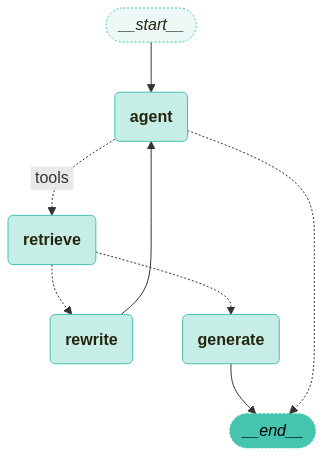

In [43]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

In [44]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, invoke_graph, random_uuid

config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

inputs = {
    "messages": [
        ("user", "삼성전자가 개발한 생성형 AI 의 이름은?"),
    ]
}

invoke_graph(graph, inputs, config)


🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  pdf_retriever (call_n2SZzoyb3UggkkfvfWgYx2RF)
 Call ID: call_n2SZzoyb3UggkkfvfWgYx2RF
  Args:
    query: 삼성전자 생성형 AI 이름
==== [DECISION: DOCS RELEVANT] ====

🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: pdf_retriever

<document><context>▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10
▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11
▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12</context><metadata><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>1</page></metadata></document>

<document><context>SPRi AI Brief |
2023-12월호
삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개
KEY Contents
n 삼성전자가 온디바이스에서 작동 가능하며 언어,